In [ ]:
#pip install torch torchvision matplotlib transformers


Imports Libraries

In [ ]:
# Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch and torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models

# Hugging Face Transformers
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Custom project imports
from src.dataset_loader import ImageDataset  # Custom dataset class that reads from a CSV
import config  # Configuration file with paths and class names


# **📦 Phase: Data Preparation Pipeline**
This phase prepares the image data for model training and evaluation. It defines separate transformation pipelines for training (including data augmentation) and testing (standardized preprocessing). The dataset is loaded from a CSV file using a custom ImageDataset class, which reads image paths and encodes class labels. The full dataset is then split into training and test subsets using an 80/20 ratio. Finally, PyTorch DataLoaders are created to efficiently load batches of transformed data for use in the training loop and evaluation process.





In [ ]:
# 1. Define image transformations

# These transformations will be applied to training images for data augmentation
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally (augmentation)
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast
    transforms.ToTensor(),  # Convert PIL Image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize pixel values to [-1, 1]
                         std=[0.5, 0.5, 0.5])
])

# These transformations will be applied to test images (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size expected by the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize pixel values
                         std=[0.5, 0.5, 0.5])
])

# 2. Load the dataset from a CSV file

# This dataset reads image file paths and labels from a CSV file
# encode=True converts string labels (e.g. "real", "cartoon") to integers (0, 1)
full_dataset = ImageDataset(csv_file=config.CSV_PATH, transform=None, encode=True)

# 3. Split the dataset into training and testing sets

# Use 80% of the data for training and 20% for testing
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# random_split creates two subsets of the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# '. Assign transforms to each split

# Apply training transformations only to the training set
train_dataset.dataset.transform = transform_train

# Apply testing transformations only to the test set
test_dataset.dataset.transform = transform_test

# 5. Create PyTorch DataLoaders

# DataLoaders batch the data and optionally shuffle it
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle for training
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffle for testing


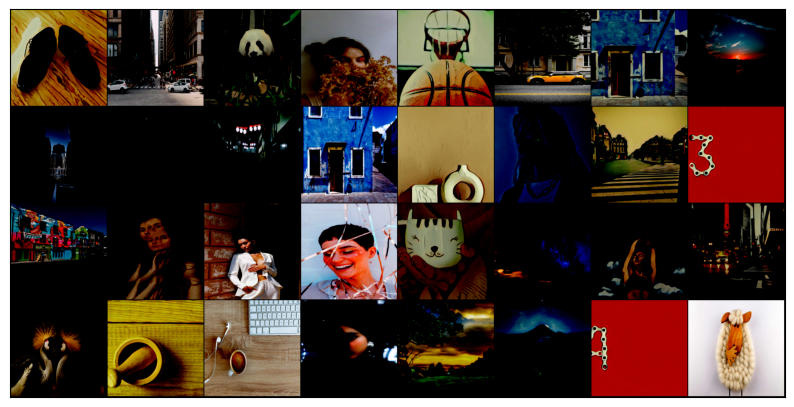

In [ ]:
# Function to display a grid of images
def show_images(img):
    plt.figure(figsize=(10, 8))  # Set the figure size for better visibility
    # Convert the image tensor from (C, H, W) to (H, W, C) format for matplotlib
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())  # Remove x-axis ticks
    plt.yticks(())  # Remove y-axis ticks
    plt.show()

# Create an iterator from the training DataLoader
train_iter = iter(train_loader)

# Retrieve the next batch of images and labels from the iterator
images, labels = next(train_iter)

# Display the batch of images as a single grid
# torchvision.utils.make_grid arranges the batch into a grid layout
show_images(torchvision.utils.make_grid(images))



In [ ]:
print("train dataset size:", train_size)
print("validation dataset size:", test_size)

train dataset size: 240
validation dataset size: 60


# **🧠 Model Definitions and Training Pipeline**
This section defines two deep learning models for binary image classification: a CNN-based ResNet-18 and a Transformer-based Vision Transformer (ViT). It also includes a general-purpose training and evaluation loop that logs both loss and accuracy for each epoch. The models are built using PyTorch and Hugging Face Transformers, and the training function supports any compatible image classification model.

In [ ]:
# 1. CNN Model: ResNet-18

class CNNModel_ResNet18(nn.Module):
    def __init__(self):
        super(CNNModel_ResNet18, self).__init__()
        # Load pretrained ResNet-18 from torchvision
        self.model = models.resnet18(pretrained=True)
        # Replace the final fully connected layer to match binary classification (2 classes)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)

    def forward(self, x):
        return self.model(x)


# 2. Vision Transformer (ViT) Model

class ViTModel_Normal(nn.Module):
    def __init__(self):
        super(ViTModel_Normal, self).__init__()
        # Load a pretrained ViT model from Hugging Face and adapt it for 2-class classification
        self.model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224-in21k', num_labels=2
        )

    def forward(self, x):
        # Return only the classification logits
        return self.model(x).logits


# 3. Training and Evaluation Function

def train_model(model, train_loader, test_loader, num_epochs=10, lr=0.001):
    # Define the loss function (cross-entropy for classification)
    criterion = nn.CrossEntropyLoss()
    # Use Adam optimizer for model parameter updates
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to track training and test loss across epochs
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # --- Training loop ---
        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagate gradients
            optimizer.step()  # Update model weights

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))  # Average training loss
        train_accuracy = correct / total * 100

        # --- Evaluation loop ---
        model.eval()  # Set model to evaluation mode
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient tracking
            test_loss = 0.0
            for images, labels in test_loader:
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                test_loss += loss.item()

                # Calculate test accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            test_losses.append(test_loss / len(test_loader))  # Average test loss
            test_accuracy = correct / total * 100

        # Print metrics for current epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss/len(test_loader):.4f}, '
              f'Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, test_losses


# **🚀 Model Training Execution**
This block handles the actual training and saving of the models. It initializes both a ResNet-18 CNN and a Vision Transformer (ViT), runs the training loop on each model, and stores the trained weights for later use.

In [ ]:
# 1. Initialize the models

# Instantiate a ResNet-18 CNN model
cnn_model_resnet18 = CNNModel_ResNet18()

# Instantiate a Vision Transformer (ViT) model
vit_model = ViTModel_Normal()

# 2. Train the models

# --- Train ResNet-18 (commented out for now) ---
print("Training the CNN model - ResNet-18...")
cnn_resnet18_train_losses, cnn_resnet18_test_losses = train_model(
     cnn_model_resnet18, train_loader, test_loader
 )
 torch.save(cnn_model_resnet18.state_dict(), 'cnn_resnet18_model.pth')  # Save trained CNN model

# --- Train ViT ---
print("Training the Vision Transformer (ViT) model...")
vit_train_losses, vit_test_losses = train_model(
    vit_model, train_loader, test_loader
)
torch.save(vit_model.state_dict(), 'vit_model.pth')  # Save trained ViT model


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entraînement du modèle CNN - ResNet-18...
Entraînement du modèle ViT...
Epoch [1/10], Train Loss: 0.7165, Train Accuracy: 54.17%, Test Loss: 0.7013, Test Accuracy: 41.67%
Epoch [2/10], Train Loss: 0.6386, Train Accuracy: 66.25%, Test Loss: 0.7799, Test Accuracy: 36.67%
Epoch [3/10], Train Loss: 0.5741, Train Accuracy: 71.25%, Test Loss: 1.1345, Test Accuracy: 38.33%
Epoch [4/10], Train Loss: 0.5049, Train Accuracy: 78.75%, Test Loss: 0.5762, Test Accuracy: 66.67%
Epoch [5/10], Train Loss: 0.5407, Train Accuracy: 75.42%, Test Loss: 0.5352, Test Accuracy: 81.67%
Epoch [6/10], Train Loss: 0.6096, Train Accuracy: 68.75%, Test Loss: 0.7582, Test Accuracy: 48.33%
Epoch [7/10], Train Loss: 0.4631, Train Accuracy: 77.92%, Test Loss: 0.4887, Test Accuracy: 75.00%
Epoch [8/10], Train Loss: 0.3546, Train Accuracy: 82.92%, Test Loss: 0.4400, Test Accuracy: 81.67%
Epoch [9/10], Train Loss: 0.2153, Train Accuracy: 92.92%, Test Loss: 0.5085, Test Accuracy: 83.33%
Epoch [10/10], Train Loss: 0.2955, Tr